# Training neural networks

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


plt.style.use("dark_background")

+ Linear regression had an analytic equation for the weight matrix $\boldsymbol{\theta}$ that minimized the cost function. Usually we aren't so lucky as to have a solvable convex optimization problem

+ The next best thing is to have an optimization problem (possibly non-convex) where the loss is a smooth, differentiable function of the weights. In this case, we get to use gradient descent.

#### What if our problem is non-differentiable?
+ Brute force (try random parameters and see what gives the best result).
+ Genetic algorithms, reinforcement learning
+ Can attempt to use gradient descent, but we need to use a surrogate function that is differentiable


### Our test problem: predicting the Reynolds number of a turbulent flow

+ Because we are going to use fully-connected nets, we downsample the dataset substantially.

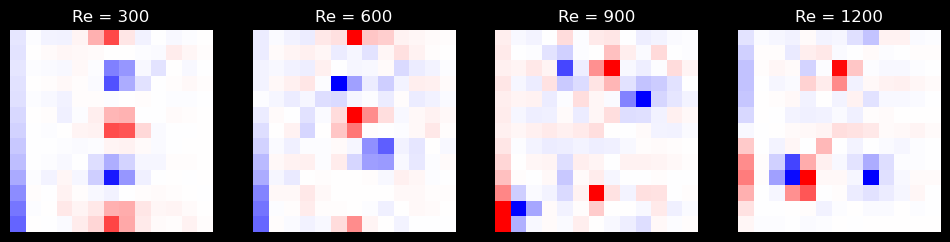

In [220]:
## Load the Reynold number regression dataset

from sklearn.model_selection import train_test_split


class ReynoldsDataset:
    """
    Class to load the Reynolds number classification dataset
    
    Parameters:
        downsample (int): Factor by which to downsample the dataset
        split (float): Fraction of data to use for testing
        fourier_features (bool): Whether to use Fourier features instead of real space
        observable (str): Which observable to use for the dataset. Options are "vorticity", "velocity", "magnitude", and "divergence"
    """

    def __init__(self, downsample=1, split=0.2, fourier_features=False, observable="vorticity"):

        all_vorticity_fields = list()
        all_reynolds_numbers = list()

        # Load simulations for different Reynolds numbers
        re_vals = [300, 600, 900, 1200]
        for re_val in re_vals:

            # Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
            # where the first dimension is the time index, the second and third dimensions are the
            # x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
            vfield = np.load(
                f"../resources/von_karman_street/vortex_street_velocities_Re_{re_val}_largefile.npz", 
                allow_pickle=True
            )

            if observable == "vorticity":
                # Calculate the vorticity, which is the curl of the velocity field
                vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]
            elif observable == "velocity":
                vort_field = vfield
            elif observable == "magnitude":
                vort_field = np.sqrt(np.sum(vfield**2, axis=-1))
            elif observable == "divergence":
                vort_field = np.diff(vfield, axis=1)[..., :-1, 0] + np.diff(vfield, axis=2)[:, :-1, :, 1]
            else:
                raise ValueError("Unknown observable type")

            # Calculate the vorticity, which is the curl of the velocity field
            vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]

            # Take wake field only
            vort_field = vort_field[::6, -127:, :]

            # downsample the dataset
            vort_field = vort_field[:, ::downsample, ::downsample]

            all_vorticity_fields.append(vort_field)
            all_reynolds_numbers.extend(re_val * np.ones(vort_field.shape[0]))

        self.data_shape = vort_field[0].shape

        all_vorticity_fields = np.vstack(all_vorticity_fields)
        all_reynolds_numbers = np.array(all_reynolds_numbers)

        X = np.reshape(all_vorticity_fields, (all_vorticity_fields.shape[0], -1))
        y = all_reynolds_numbers

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X = np.vstack([X_train, X_test])
        self.y = np.hstack([y_train, y_test])

    def reshape(self, X):
        if len(X.shape) == 1:
            return X.reshape(self.data_shape)
        elif len(X.shape) == 2:
            return np.reshape(X, (X.shape[0], 127, 127))
        else:
            raise ValueError("X must be a 1D or 2D array")
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = ReynoldsDataset(downsample=10)

## plot examples of the dataset
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i, re in enumerate([300, 600, 900, 1200]):
    ax[i].imshow(dataset.reshape(dataset.X[dataset.y == re][0]), cmap='bwr', vmin=-0.01, vmax=0.01)
    ax[i].set_title(f"Re = {re}")
    ax[i].axis("off")
plt.show()


In [177]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate='constant',
                     learning_rate_init=0.001, max_iter=1000, random_state=0, batch_size=32)


X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test

mlp.fit(X_train, y_train)

## Score
print("R^2 score: %f" % mlp.score(X_test, y_test))

R^2 score: 0.990988


# How do we train this?

Given a model 
$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

with known true labels $y$ for every $\mathbf{x}$, we can update the weights with gradient descent:

$$\theta_{i+1} = \theta_i - \eta \frac{\partial \mathcal{L}}{\partial \theta_i}$$

where $\eta$ is the learning rate. Given a training set with $N$ examples, we usually take the average of the gradient computed over the $N$ examples.


### Linear model

The model is given by

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$$

For linear regression, we typically use the mean-squared loss function,

$$\mathcal{L} = \frac{1}{2} \sum_{i=1}^N (\hat{y}_i - y_i)^2$$

$$
\frac{\partial \mathcal{L}}{\partial \theta_j} = \sum_{i=1}^N (\hat{y}_j - y_j) x_{ij}
$$

where $i$ indexes the data points and $j$ indexes the features.

### Logistic model:

The model is

$$\hat{y} = \frac{1}{1 + e^{-\theta_0 - \theta_1 x_1 - \theta_2 x_2 - \cdots - \theta_n x_n}}$$

Instead of mean-squared error, logistic models are often trained using cross-entropy loss:

$$\mathcal{L} = - \sum_{i=1}^N y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i)$$

$$
\frac{\partial \hat{y}}{\partial \theta_j} = -\sum_{i=1}^N \dfrac{1}{4} x_{ij} \log(2 y_i - 1) \text{sech}^2\left(\dfrac{\theta_j x_{ij}}{2}\right)
$$



### Multivariate Linear model

The model is

$$\hat{\mathbf{y}} = \boldsymbol{\theta} \mathbf{X}$$

where $\mathbf{x}$ is a $1 \times D$ matrix with $N$ data points and $D$ features, the weight matrix $\boldsymbol{\theta} \in \mathbb{R}^{M \times D}$ , and the prediction vector is $\hat{\mathbf{y}} \in \mathbb{R}^M$. Usually, we work with the data matrix $X = \{ \mathbf{x}_i \} \in \mathbb{R}^{N \times D}$.

The mean-squared loss function is

$$\mathcal{L} = \frac{1}{2} \sum_{i=1}^N (\hat{\mathbf{y}}_i - \mathbf{y}_i)^T(\hat{\mathbf{y}}_i - \mathbf{y}_i)$$

The gradient is

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} = \sum_{i=1}^N (\hat{\mathbf{y}}_i - \mathbf{y}_i) \mathbf{x}_i^T
$$

Notice that the gradient is a matrix $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}}  \in  \mathbb{R}^{M \times D}$, where each row is the gradient of the loss with respect to the weights for a single output. This means that we have update values separately for each element of the weight matrix. Also, note that the right hand side is an outer product, while the forward pass is an inner product.

<!-- ### Neural network

The model is

$$\hat{y} = f(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n)$$

where $f$ is a non-linear function. For example, $f$ could be a sigmoid function:

$$f(x) = \frac{1}{1 + e^{-x}}$$ -->




## Going deeper: Backpropagation

### Forward pass

$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$
for concreteness, we will use the sigmoid nonlinearity $\sigma(x) = \frac{1}{1 + e^{-x}}$.

We start by breaking this into single steps

$$
\mathbf{h}_1^{u} = \boldsymbol{\theta}_1 \mathbf{x}
$$

$$
\mathbf{h}_1 = \sigma(\mathbf{h}_1^{u})
$$

$$
\mathbf{h}_2^{u} = \boldsymbol{\theta}_2 \mathbf{h}_1
$$

$$
\hat{\mathbf{y}} = \sigma(\mathbf{h}_2^{u})
$$


### Backward pass

Suppose we pass an input $\mathbf{x}$ and get an output $\hat{\mathbf{y}}$, and we know the true output is $\mathbf{y}$.

If we are using the mean-squared error loss function, then for a single training example $\mathbf{y}$, the loss is

$$
\mathcal{L} = \frac{1}{2} (\hat{\mathbf{y}} - \mathbf{y})^\top(\hat{\mathbf{y}} - \mathbf{y})
$$

We want to update all the parameters $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$ to minimize this loss.

We traverse the network *backwards* in order to compute gradients.

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} = \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{h}_2^{u}} \frac{\partial \mathbf{h}_2^{u}}{\partial \boldsymbol{\theta}_2}
$$

Solving this sequence from left-to-right,

$$
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} = \hat{\mathbf{y}} - \mathbf{y}
$$

$$
\frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{h}_2^{u}} = \hat{\mathbf{y}} (1 - \hat{\mathbf{y}})
$$

$$
\frac{\partial \mathbf{h}_2^{u}}{\partial \boldsymbol{\theta}_2} = \mathbf{h}_1^\top
$$

Putting this all together,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} = (\hat{\mathbf{y}} - \mathbf{y}) \odot \hat{\mathbf{y}} (1 - \hat{\mathbf{y}}) \mathbf{h}_1^\top
$$

where $\odot$ is the element-wise product.

We can now compute the gradient for the first layer.

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_1} = 

\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{h}_2^{u}} 


 \frac{\partial \mathbf{h}_2^{u}}{\partial \mathbf{h}_1} \frac{\partial \mathbf{h}_1}{\partial \mathbf{h}_1^{u}} \frac{\partial \mathbf{h}_1^{u}}{\partial \boldsymbol{\theta}_1}
$$

We can combine the first two terms, which we already calculated above, and then solve from left to right.

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{h}_2^{u}} = (\hat{\mathbf{y}} - \mathbf{y}) \odot \hat{\mathbf{y}} (1 - \hat{\mathbf{y}}) \boldsymbol{\theta}_2^\top
$$

$$
\frac{\partial \mathbf{h}_2^{u}}{\partial \mathbf{h}_1} = \mathbf{h}_1 (1 - \mathbf{h}_1)
$$

$$
\frac{\partial \mathbf{h}_1}{\partial \mathbf{h}_1^{u}} = \mathbf{h}_1^{u} (1 - \mathbf{h}_1^{u})
$$

$$
\frac{\partial \mathbf{h}_1^{u}}{\partial \boldsymbol{\theta}_1} = \mathbf{x}^\top
$$

Putting this all together,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_1} = (\hat{\mathbf{y}} - \mathbf{y}) \odot \hat{\mathbf{y}} (1 - \hat{\mathbf{y}}) \boldsymbol{\theta}_2^\top \odot \mathbf{h}_1 (1 - \mathbf{h}_1) \odot \mathbf{h}_1^{u} (1 - \mathbf{h}_1^{u}) \mathbf{x}^\top
$$



### Some things to note

+ Several of the "intermediate" values we computed during the forward pass reappear here. If we cached these values, then we don't have to recompute them during the backward pass. 

+ Notice that when we compute the "forward" pass we start with the innermost portion of the function computation, and then work our way out. For the backwards pass, we start with the outermost portion of the function computation, and work our way in. 

+ Notice that the sigmoid function's derivative is a function of its output. This is a common pattern in autodiff. 

+ In order to keep track of indicies and transposes, it helps to think about the dimensions of the input/output of each primitive operation.

+ It's useful to remember the some [rules for matrix multiplication:](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)

$$
\frac{\partial\mathbf{A} \mathbf{B}}{\partial \mathbf{A}} = \mathbf{B}^\top, \qquad
\frac{\partial\mathbf{A} \mathbf{B}}{\partial \mathbf{B}} = \mathbf{A}
$$
<!-- 
These left-right rules are also used in the derivation of the linear regression pseudoinverse global solution.

Additionally, we should remember the chain rule for derivatives:
$$
\frac{\partial\mathbf{A}(u) \mathbf{B}(u)}{\partial u} = \frac{\partial\mathbf{A}(u)}{\partial u} \mathbf{B}(u) + \mathbf{A}(u) \frac{\partial\mathbf{B}(u)}{\partial u}
$$ -->


# A reminder regarding indices...

For a single datapoint (vector) $\mathbf{x} \in \mathbb{R}^{d}$, the forward pass of a multilayer perceptron is
$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

We normally aggregate many datapoints into a matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$, where $N$ is the number of datapoints. In this case, the forward pass returns $\hat{\mathbf{Y}} \in \mathbb{R}^{N \times 1}$, where each row is the prediction for a single datapoint. For some regression problems (such as the fluid forecasting problem on the homework), $\hat{\mathbf{Y}} \in \mathbb{R}^{N \times M}$

The first index, the data or "batch" index, is usually vectorized: it passes right through the model, since every data point has an output. The first index usually recieves special treatment in high-level packages like PyTorch and TensorFlow, since it is often used to aggregate gradients from multiple datapoints.

The loss function is usually a function of the entire dataset, including the batch index. For example, the mean squared loss is
$$
\mathcal{L}(X, \mathbf{y}, \boldsymbol{\theta}) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} (\hat{y}_i - y_i)^2
$$

For a multivariate prediction problem, the loss function is

$$
\mathcal{L}(X, Y, \boldsymbol{\theta}) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \|\hat{\mathbf{y}}_i - \mathbf{y}_i\|^2
$$

where $\hat{\mathbf{y}}_i \in \mathbb{R}^{M}$ and $\mathbf{y}_i \in \mathbb{R}^{M}$.


Importantly, when we compute gradients of the loss, we treat *the entire dataset* $X$, the true labels $Y$, and even the current predicted labels $\hat{Y}$ as a fixed set of constant parameters

# Backpropagation as a graph traversal


<img src="../resources/backprop1.png" width="750">
<img src="../resources/backprop2.png" width="750">

*Diagrams from [UW CSE599W lecture notes](https://dlsys.cs.washington.edu/pdf/lecture4.pdf)*

## What does the code actually look like?

+ We will put all of these ideas together into a multilayer perceptron class. 

+ We will use the sigmoid activation function, and the mean-squared error loss function.

In [208]:
class MultiLayerPerceptron:
    """An MLP for regression with mean squared loss and no bias"""

    def __init__(self, hidden_layer_sizes=(100,), activation='relu', 
                 learning_rate=0.001, max_iter=1000, random_state=0, batch_size=32):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.batch_size = batch_size

    def _init_weights(self, n_features):
        """Initialize the weights of the network"""
        rng = np.random.RandomState(self.random_state)
        self.coefs_ = []
        self.biases_ = []
        # iterate over the layers and randomly initialize a weight matrix
        # of shape (n_hidden, n_features) for the layer
        # and a bias vector of shape (n_hidden,)
        for n_hidden in self.hidden_layer_sizes:
            self.coefs_.append(rng.normal(size=(n_hidden, n_features),
                                          scale=1.0 / np.sqrt(n_features)))
            self.biases_.append(rng.normal(size=n_hidden, scale=1.0 / np.sqrt(n_hidden)))
            n_features = n_hidden

        # We need to initialize the weights of the last layer
        self.coefs_.append(rng.normal(size=(1, n_features),
                                      scale=1.0 / np.sqrt(n_features)))
        self.biases_.append(rng.normal(size=1, scale=1.0 / np.sqrt(n_features)))

    def _forward_pass(self, X):
        """Compute the output of the network for input X"""
        activations = X
        activations = [X]
        # iterate over the layers and compute the values of the neurons
        # for the layer
        for coef, bias in zip(self.coefs_[:-1], self.biases_[:-1]):
            activations.append(self._activation(np.dot(activations[-1], coef.T) + bias))
        # For the last layer, do not apply the activation function
        activations.append(np.dot(activations[-1], self.coefs_[-1].T) + self.biases_[-1])
        return activations
        

    def _activation(self, X):
        """Apply the activation function to X"""
        if self.activation == 'relu':
            return np.maximum(X, 0, X)
        elif self.activation == 'tanh':
            return np.tanh(X)
        elif self.activation == 'identity':
            return X
        else:
            raise ValueError("Unknown activation function %s" % self.activation)

    def _derivative_activation(self, X):
        """Compute the derivative of the activation function"""
        if self.activation == 'relu':
            return X > 0
        elif self.activation == 'tanh':
            return 1 - np.tanh(X) ** 2
        elif self.activation == 'identity':
            return 1
        else:
            raise ValueError("Unknown activation function %s" % self.activation)

    def _loss_mse(self, y_true, y_pred):
        """Compute the loss function"""
        return np.mean((y_pred - y_true) ** 2)

    def _loss_grad_mse(self, y_true, y_pred):
        """Compute the gradient of the loss function"""
        return (y_pred.squeeze() - y_true.squeeze())[:, None]


    def fit(self, X, y):
        """Fit the model to the data X and target y"""
        self._init_weights(X.shape[1])
        rng = np.random.RandomState(self.random_state)

        for it in range(self.max_iter):
            # Select a random batch
            batch_indices = rng.randint(X.shape[0], size=self.batch_size)
            X_batch, y_batch = X[batch_indices], y[batch_indices]

            # Forward pass
            activations = self._forward_pass(X_batch)

            # Backward pass
            deltas = self._loss_grad_mse(y_batch, activations[-1]) * self._derivative_activation(activations[-1])
            for i in range(len(self.coefs_) - 1, 0, -1):
                self.coefs_[i] -= self.learning_rate * np.dot(deltas.T, activations[i])
                self.biases_[i] -= self.learning_rate * np.mean(deltas, axis=0)
                deltas = np.dot(deltas, self.coefs_[i]) * self._derivative_activation(activations[i])

            # First layer
            self.coefs_[0] -= self.learning_rate * np.dot(deltas.T, activations[0])
            self.biases_[0] -= self.learning_rate * np.mean(deltas, axis=0)

    def predict(self, X):
        """Predict using the multi-layer perceptron"""
        activations = self._forward_pass(X)
        return activations[-1]

    def score(self, X, y):
        """Return the coefficient of determination R^2 of the prediction."""
        y_pred = self.predict(X)
        return 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)

## Generate a dataset
rng = np.random.RandomState(0)
X = np.sort(5 * rng.rand(40, 1), axis=0)
X -= np.mean(X)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(8))

# Fit regression model
mlp = MultiLayerPerceptron(hidden_layer_sizes=(100, 100), activation='relu',
                            learning_rate=0.001, max_iter=2000, random_state=0,
                            batch_size=35*5)

# from sklearn.neural_network import MLPRegressor
# mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate='constant',
#                      learning_rate_init=0.001, max_iter=1000, random_state=0, batch_size=32)


X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test

mlp.fit(X_train, y_train)

## Score
print("R^2 score: %f" % mlp.score(X_test, y_test))


        





R^2 score: -2322.922740


### Harder cases: branching paths, loops, and shared weights

+ For more sophisticated architectures, we might have multiple paths through the network. For example, we might have a residual connection, where the output of the first layer is added to the output of the second layer.

+ Backpropagation is more complicated, but as long as everything is deterministic and continuous, it should still be possible to implement all gradients at nodes.

+ Modern deep learning frameworks like PyTorch and JAX have automatic differentiation, which can find the gradient from almost anything expressible as compositions of numpy functions. This is valuable, because modern architectures can get quite complicated:

<img src="../resources/inceptionnet.png" width="350">

*Diagram from [Szegedy et al. (2014)](https://arxiv.org/abs/1409.4842)*

# Math is hard: Automatic Differentiation

+ Computing symbolic gradients of vector functions is exact but laborious

+ Numerical gradients are approximate, easy, but expensive.

+ If the input to our network is $M$-dimensional, then we need to compute $2\,M$ gradients. For a 1 Megapixel image, this is a million gradient operations per gradient descent step

*Automatic differentiation* is a technique that can compute the *exact* gradient of a function in a computationally-efficient manner.

*Backpropagation* is reverse-mode autodiff applied to deep neural networks.

In [239]:
def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

def double_well_grad(x):
    """Derivative of double well potential function"""
    return 4*x**3 - 4*x

print(double_well(0.12132987))
print(double_well_grad(0.12132987))

-0.029225168711847025
-0.4781751223381389


### Let's write out these functions in terms of basic computational steps

In [240]:
def double_well_primitive(x):
    """Decompose the double well calculation into primitive operations"""
    h1a = x**4
    h1b = 2*x**2
    h2 = h1a - h1b
    return h2

def double_well_primitive_grad(x):
    """Decompose the double well gradient calculation into primitive operations"""
    dh2dh1a = 1
    dh2dh1b = -1
    dh1adx = 4*x**3
    dh1bdx = 4*x
    dh2dx = dh2dh1a * dh1adx + dh2dh1b * dh1bdx
    return dh2dx

print(double_well_primitive(0.12132987))
print(double_well_primitive_grad(0.12132987))

-0.029225168711847025
-0.4781751223381389


### Let the computer do the work

+ Most existing deep learning frameworks are built on top of autodiff
+ Tensorflow, PyTorch, JAX, and many others allow you to specify the neural network as a function, and can compute the gradient automatically as long as everything is differentiable
+ Implictly, these networks build a computation "graph" that is later traversed backwards to compute the gradient
+ Caching forward pass values can speed up the backwards pass, since many derivatives depend on forward pass values

In [242]:
import jax

def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

print("Forward pass value:", double_well(0.12132987))
print("Analytic calculation backwards pass", double_well_grad(0.12132987))
print("Jax autodiff backwards pass", jax.grad(double_well)(0.12132987))


Forward pass value: -0.029225168711847025
Analytic calculation backwards pass -0.4781751223381389
Jax autodiff backwards pass -0.4781751


In [282]:
import jax.numpy as jnp

a = jnp.array(np.random.random((5, )))
x = jnp.array(np.random.random((5, )))

def forward_pass(x, a):
    """Forward pass of a simple neural network"""
    return jnp.tanh(a.T @ x)

def backward_pass(x, a):
    """Backward pass of a simple neural network"""
    return (1 - np.tanh(a.T @ x)**2) * x.T

print("Forward pass value:\n", forward_pass(x, a))

print("\nAnalytic calculation backwards pass:\n", backward_pass(x, a))

print("\nJax autodiff backwards pass:\n", jax.grad(forward_pass, argnums=1)(x, a))
    

Forward pass value:
 0.5584225

Analytic calculation backwards pass:
 [0.19981267 0.21903262 0.0847854  0.421329   0.42325357]

Jax autodiff backwards pass:
 [0.19981267 0.21903262 0.0847854  0.421329   0.42325357]


### Some optimization tricks

+ Instead of "full batch" gradient descent, where we compute the average of the gradient $\nabla_\theta \mathcal{L}(\theta)$ over all training examples $x_i$, we can use *stochastic gradient descent*, where we randomly sample a *subset* of the training data during each gradient descent epoch. Smaller batch sizes are more noisy, while larger batch sizes are more accurate to the global geometry of the loss function.

+  Instead of just gradient descent, we can use momentum and many other tricks we saw in optimization:
    +  Stochastic
    +  Momentum
    +  Second-order methods (e.g. Newton's method)
    +  Adaptive learning rates
    +  Constrained Optimization (e.g. L1/L2 regularization)


+ Currently, many practioners use [the Adam optimizer](https://arxiv.org/abs/1412.6980), which is a combination of momentum and weight-based learning rate adjustment. Second-order methods are less commonly used for large problems, due to the expense of finding the full Hessian, but approximates methods based on its eigenvalues are viable.

# How do different hyperparameters affect training?

Two common hyperparameters that we'll encounter when training large networks are the learning rate $\eta$ and the batch size $B$.

+ Batch size $B$: The number of training examples used to compute the gradient. Larger batch sizes are better estimators of the overall gradient of the loss landscape, but more expensive to compute. Smaller batch sizes are more noisy, but can be faster to compute. The stochasticity of small batch sizes can also help the network avoid local minima.

+ Learning rate: The size of the step taken in the direction of the gradient. If the learning rate is too small, then the network will take a long time to converge. If the learning rate is too large, then the network will oscillate around the minimum, or even diverge.

+ We'll demonstrate these hyperparameters using `scikit-learn`'s own `MLPRegressor` class, which is a multilayer perceptron for regression problems. We'll use the `adam` iterative optimization algorithm, which is a combination of momentum and adaptive learning rates.

R^2 score: 0.990988


Text(0, 0.5, 'Loss')

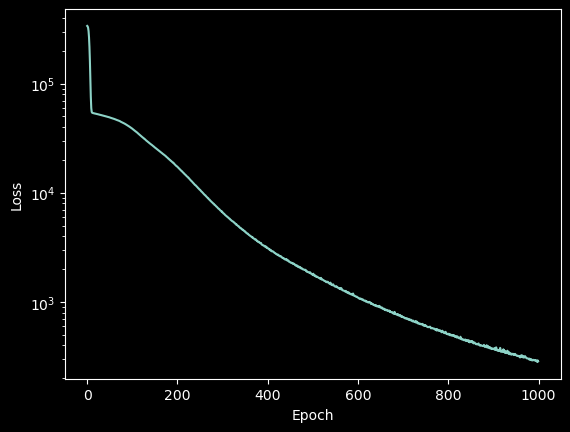

In [212]:
from sklearn.neural_network import MLPRegressor



mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate='constant',
                     learning_rate_init=0.001, max_iter=1000, random_state=0, batch_size=32)


X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test

mlp.fit(X_train, y_train)

## Score
print("R^2 score: %f" % mlp.score(X_test, y_test))

plt.semilogy(mlp.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

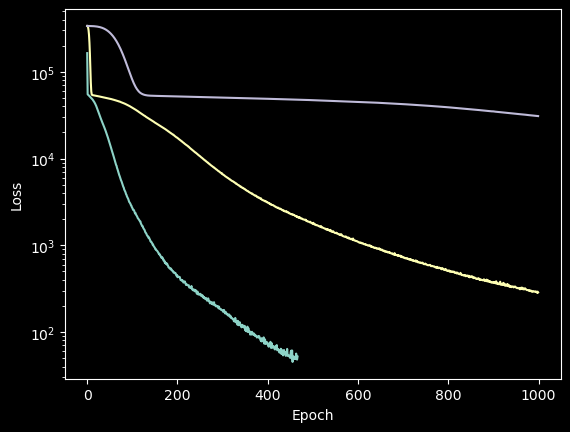

In [213]:
for batch_size_value in [2, 32, 512]:
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate='constant',
                     learning_rate_init=0.001, max_iter=1000, random_state=0, batch_size=batch_size_value)

    mlp.fit(X_train, y_train)
    plt.semilogy(mlp.loss_curve_, label=f"batch_size={batch_size_value}")
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

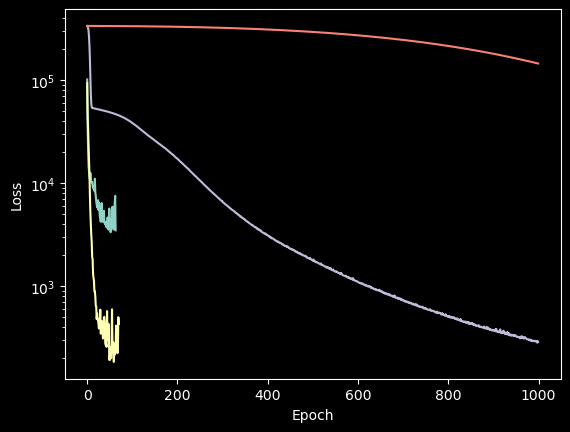

In [216]:
for lr in [1e0, 1e-1, 1e-3, 1e-5]:
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100), 
                       activation='relu', 
                       solver='adam', 
                       learning_rate='constant',
                       learning_rate_init=lr, 
                       max_iter=1000, 
                       random_state=0,
                       batch_size=32)

    mlp.fit(X_train, y_train)
    plt.semilogy(mlp.loss_curve_, label=f"learning_rate={lr}")
plt.xlabel('Epoch')
plt.ylabel('Loss')